In [12]:
import re
import os
import io
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

## Parameters

In [2]:
MAX_OOV_TOKENS = 2 #How many out of dictionary words can a song have
VOCABULARY_SIZE = 2500 #Amount of the words in the dictionary
SEQUENCE_LENGTH = 16 #Length of the sequence to predict the next word to
STEP_SIZE = 1 #Distance between sequences

In [3]:
df_data = pd.read_csv("data/lyric_dataset.csv") #Change this input location of the dataset
df_data.head()

,Artist,Title,Lyrics,URL
0,2 Fast,Burning Up The Night (Total Fire),One more a burning night\nOne more a death ins...,https://www.eurobeat-prime.com/lyrics.php?lyri...
1,70's Queens Feat. Annalise & Virginelle,Get Up And Move It,Trying to fight against a day never ending\nWa...,https://www.eurobeat-prime.com/lyrics.php?lyri...
2,7th Heaven,It's My Life,Don't run to me just when you need me\nTo save...,https://www.eurobeat-prime.com/lyrics.php?lyri...
3,7th Heaven,Last Christmas,[Chorus (2x):]\nLast Christmas\nI gave you my ...,https://www.eurobeat-prime.com/lyrics.php?lyri...
4,90 Degrees Feat. Annalise & Mirka,I Am A Pacifist,Peace! \nPeace!\nPeace!\nPeace!\n\nOh Oh Oh\nH...,https://www.eurobeat-prime.com/lyrics.php?lyri...


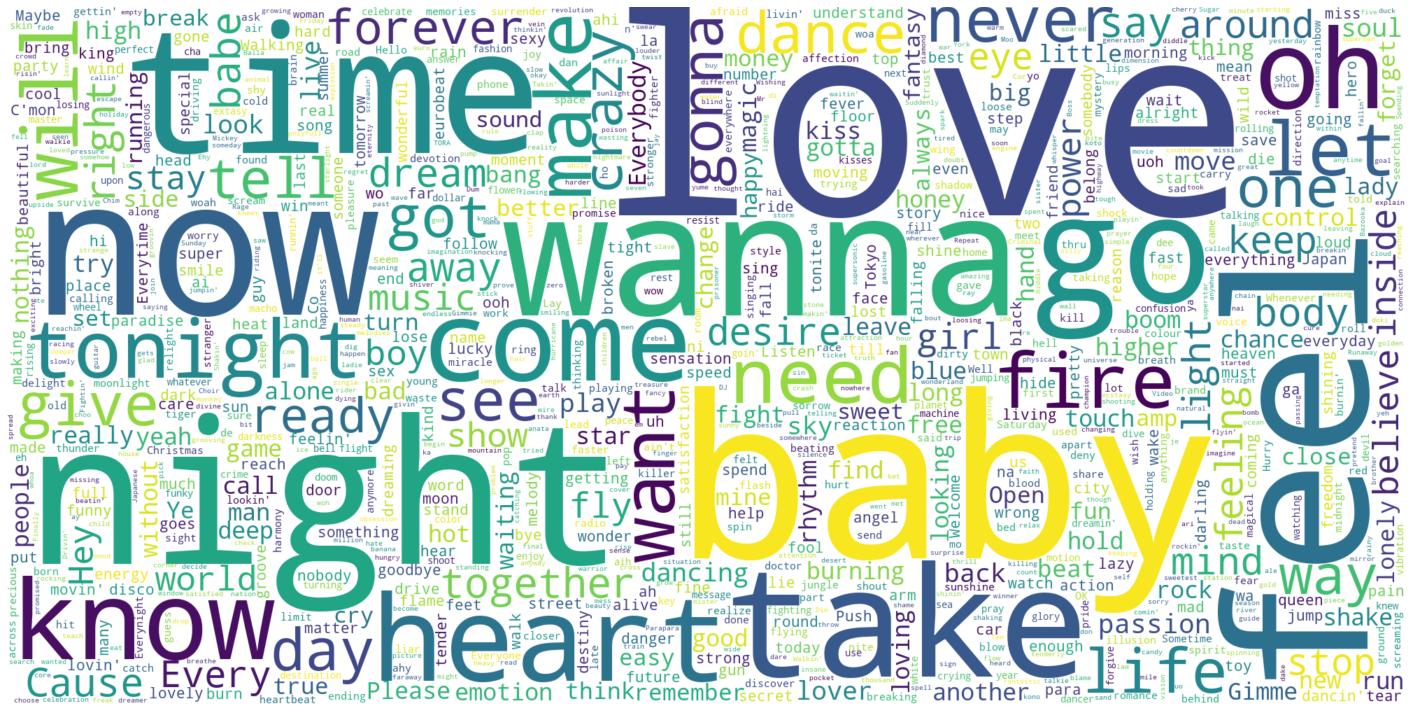

In [ ]:
wordcloud = WordCloud(background_color="white", max_words=980, width=2000, height=1000, collocations=False).generate(" ".join(df_data["Lyrics"]))
wordcloud.to_file("output/wordcloud.png") #Change this output location for the .png image

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

### Clean the data
1. Remove all special characters and empty lines. Replace newlines with a custom tag.
2. Create the tokenizer.
3. Tokenize songs and remove songs with more out of dictionary words than `MAX_OOV_TOKENS`. Higher values reduce the variety of the dataset.

In [4]:
#Print the original text
print(f"Original text:\n{df_data['Lyrics'][0][0:74]}")

songs = [re.sub("[^A-Za-z0-9\ \n]", "", lyric).replace("\n\n", "\n").replace("\n", " <br> ") for lyric in df_data["Lyrics"]]

#Print the first song without special characters or empty lines
print(f"Cleaned text:\n{songs[0][0:84]}")

Original text:
One more a burning night
One more a death inside
One more a dream to live

Cleaned text:
One more a burning night <br> One more a death inside <br> One more a dream to live 


In [5]:
# Replace original texts with cleaned data
df_data['Lyrics'] = songs

In [6]:
df_data.head()

,Artist,Title,Lyrics,URL
0,2 Fast,Burning Up The Night (Total Fire),One more a burning night <br> One more a death...,https://www.eurobeat-prime.com/lyrics.php?lyri...
1,70's Queens Feat. Annalise & Virginelle,Get Up And Move It,Trying to fight against a day never ending <br...,https://www.eurobeat-prime.com/lyrics.php?lyri...
2,7th Heaven,It's My Life,Dont run to me just when you need me <br> To s...,https://www.eurobeat-prime.com/lyrics.php?lyri...
3,7th Heaven,Last Christmas,Chorus 2x <br> Last Christmas <br> I gave you ...,https://www.eurobeat-prime.com/lyrics.php?lyri...
4,90 Degrees Feat. Annalise & Mirka,I Am A Pacifist,Peace <br> Peace <br> Peace <br> Peace <br> O...,https://www.eurobeat-prime.com/lyrics.php?lyri...


In [7]:
df_train_full, df_test_full = train_test_split(df_data, test_size=0.2, random_state=42)

In [8]:
print(df_train_full.shape, df_test_full.shape)

(3643, 4) (911, 4)


In [9]:
df_train, df_valid = train_test_split(df_train_full, test_size=0.2, random_state=42)
df_test_eval, df_test_unseen = train_test_split(df_test_full, test_size=0.8, random_state=42)

In [10]:
print(df_train.shape, df_valid.shape) 
print(df_test_eval.shape, df_test_unseen.shape)

(2914, 4) (729, 4)
(182, 4) (729, 4)


## Fit Tokenizer on training data

In [11]:
tokenizer = Tokenizer(oov_token="<OOV>", num_words=VOCABULARY_SIZE, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(df_train['Lyrics'].values)
reverse_word_index = dict([(value, key) for key, value in tokenizer.word_index.items()])

#Print the word index
#print(tokenizer.word_index)
print(len(tokenizer.word_index))
print(dict(list(tokenizer.word_index.items())[:20]))

9865
{'<OOV>': 1, '<br>': 2, 'you': 3, 'the': 4, 'i': 5, 'me': 6, 'my': 7, 'to': 8, 'and': 9, 'your': 10, 'a': 11, 'love': 12, 'in': 13, 'is': 14, 'for': 15, 'of': 16, 'baby': 17, 'be': 18, 'on': 19, 'im': 20}


### We save the Tokenizer-object in order to use it in other environments, see 

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#to_json

In [13]:
tokenizer_json = tokenizer.to_json()
with io.open("data/tokenizer.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

### Create sequences
1. For each song: take a sequence of words size `SEQUENCE_LENGTH` and use the next word as the label.
2. Convert the labels to a binary class matrix.

In [ ]:
def create_sequences(korpus):
    #Convert words in songs to their dictionary token
    sequences = tokenizer.texts_to_sequences(korpus)
    
    #Remove all songs with more out of dictionary words than MAX_OOV_TOKENS
    cleaned_sequences = list(filter(lambda x: x.count(1) < MAX_OOV_TOKENS + 1, sequences))
    
    sequences, labels = [], []
    for sequence in cleaned_sequences:
        for i in range(0, len(sequence) - SEQUENCE_LENGTH, STEP_SIZE):
            #Add the sequence
            sequences.append(sequence[i:i + SEQUENCE_LENGTH])

            #Add the label (next word)
            labels.append(sequence[i + SEQUENCE_LENGTH])

    sequences = np.array(sequences)
    labels = np.array(labels)
    
    print(sequences.shape, labels.shape) 
    
    return sequences, labels

In [ ]:
train_sequences, train_labels = create_sequences(df_train['Lyrics'])
valid_sequences, valid_labels = create_sequences(df_valid['Lyrics'])
eval_sequences, eval_labels = create_sequences(df_test_eval['Lyrics'])
unseen_sequences, unseen_labels = create_sequences(df_test_unseen['Lyrics'])

(214309, 16) (214309,)
(45284, 16) (45284,)
(11775, 16) (11775,)
(44895, 16) (44895,)


In [ ]:
#Print training sequences and corresponding labels
print("Index. Sequence -> Label")

for i in range(0, 5):
    print(f"{i}. {[reverse_word_index[num] for num in train_sequences[i]]}  ->  {reverse_word_index[train_labels[i]]}")

Index. Sequence -> Label
0. ['time', 'to', 'see', 'you', 'again', '<br>', 'im', 'gonna', 'call', 'you', 'tonite', '<br>', 'now', '<OOV>', 'my', 'neverending']  ->  love
1. ['to', 'see', 'you', 'again', '<br>', 'im', 'gonna', 'call', 'you', 'tonite', '<br>', 'now', '<OOV>', 'my', 'neverending', 'love']  ->  <br>
2. ['see', 'you', 'again', '<br>', 'im', 'gonna', 'call', 'you', 'tonite', '<br>', 'now', '<OOV>', 'my', 'neverending', 'love', '<br>']  ->  burning
3. ['you', 'again', '<br>', 'im', 'gonna', 'call', 'you', 'tonite', '<br>', 'now', '<OOV>', 'my', 'neverending', 'love', '<br>', 'burning']  ->  up
4. ['again', '<br>', 'im', 'gonna', 'call', 'you', 'tonite', '<br>', 'now', '<OOV>', 'my', 'neverending', 'love', '<br>', 'burning', 'up']  ->  <br>


In [ ]:
np.save(os.path.sep.join(['data', 'train_sequences.npy']), train_sequences)
np.save(os.path.sep.join(['data', 'train_labels.npy']), train_labels)

np.save(os.path.sep.join(['data', 'valid_sequences.npy']), valid_sequences)
np.save(os.path.sep.join(['data', 'valid_labels.npy']), valid_labels)

np.save(os.path.sep.join(['data', 'eval_sequences.npy']), eval_sequences)
np.save(os.path.sep.join(['data', 'eval_labels.npy']), eval_labels)

np.save(os.path.sep.join(['data', 'unseen_sequences.npy']), unseen_sequences)
np.save(os.path.sep.join(['data', 'unseen_labels.npy']), unseen_labels)